<a href="https://colab.research.google.com/github/LordLean/Machine-Learning/blob/master/Kaggle/ML_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexholder","key":"<>"}'}

In [2]:
# Make directory and copy.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#!pip install kaggle # Install kaggle.

# Change access permissions.
!chmod 600 /root/.kaggle/kaggle.json

#!kaggle datasets list # Lists kaggle datasets.

# Download using Kaggle API.
!kaggle competitions download -c brighton-a-memorable-city

# Unzip data
!unzip additional_training.csv
!unzip training.csv
!unzip testing.csv

# List files in dir.
# !ls

  0% 0.00/1.65M [00:00<?, ?B/s]
100% 1.65M/1.65M [00:00<00:00, 55.6MB/s]
  0% 0.00/30.0 [00:00<?, ?B/s]
100% 30.0/30.0 [00:00<00:00, 25.4kB/s]
  0% 0.00/81.9k [00:00<?, ?B/s]
100% 81.9k/81.9k [00:00<00:00, 72.5MB/s]
 64% 9.00M/14.2M [00:00<00:00, 16.0MB/s]
100% 14.2M/14.2M [00:00<00:00, 24.1MB/s]
 85% 73.0M/85.7M [00:01<00:00, 29.9MB/s]
100% 85.7M/85.7M [00:02<00:00, 44.5MB/s]
  0% 0.00/19.6k [00:00<?, ?B/s]
100% 19.6k/19.6k [00:00<00:00, 19.7MB/s]
Archive:  additional_training.csv.zip
  inflating: additional_training.csv  
Archive:  training.csv.zip
  inflating: training.csv            
Archive:  testing.csv.zip
  inflating: testing.csv             


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix

from sklearn.impute import SimpleImputer

from imblearn.under_sampling import TomekLinks

from sklearn.utils import shuffle, resample

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
train = pd.read_csv("/content/training.csv")
test = pd.read_csv("/content/testing.csv")
test_proportions = pd.read_csv("/content/test_proportions.csv")
additional_train = pd.read_csv("/content/additional_training.csv")

Length match: True
Proportional Accuracy: 0.8309178743961353
   0    1
0  1   31
1  4  171


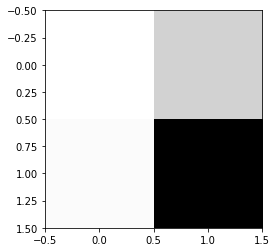

In [99]:
#@title Example Split on Training Data.

# Train on train, test on train[split].

split_spot = 40

train_split_train = train.iloc[:split_spot, 1:-1].to_numpy(copy=True)
train_pred_train = train.iloc[:split_spot, -1].to_numpy(copy=True)
print("Length match: {}".format(len(train_split_train) == len(train_pred_train)))

train_split_test = train.iloc[split_spot: ,1:-1].to_numpy(copy=True)
train_pred_test = train.iloc[split_spot: ,-1].to_numpy(copy=True)

X = train_split_train
y = train_pred_train 

clf = MLPClassifier(solver="lbfgs", alpha=1e-5, random_state=1)

clf.fit(X,y)

predictions = clf.predict(train_split_test)

accuracy = 0 

for i, (p1,p2) in enumerate(zip(predictions, train_pred_test)):
  if p1 == p2:
    accuracy += 1

print("Proportional Accuracy: {}".format(accuracy / len(predictions)))


conf = confusion_matrix(train_pred_test, predictions)
df = pd.DataFrame(conf)
print(df)

plt.imshow(conf, cmap="binary", interpolation="None")
#plt.axis("off")
plt.show()

In [0]:
#@title FUNCTION - GRAPH FUNCTIONS { vertical-output: true }

# Graph-rep. Functions.

# Plot bar.
def plotbargraph(trn, bars=True):

  # Data representation:

  # Get all observed predictions 0 / 1.
  trn_observed = trn.iloc[:, -1]
  # .values()
  y_ = trn_observed.to_numpy(copy=True)

  # Training ---
  trn_c0 = np.count_nonzero(y_ == 0)
  trn_c1 = np.count_nonzero(y_ == 1)

  autolabel_vals = [trn_c0,trn_c1] # Hold vals for rect labels.

  trn_c0 = round((trn_c0/len(y_)*100),2)
  trn_c1 = round((trn_c1/len(y_)*100),2)
  trn_bar = [trn_c0,trn_c1] # Hold vals for bar plot.


  # Testing ---
  tst_c0 = float(test_proportions.iloc[0,0][:6])

  # Hold vals for rect labels.
  autolabel_vals.append(tst_c0*len(test))
  autolabel_vals.append((1-tst_c0)*len(test))

  tst_c0 = round((tst_c0*100),2)
  tst_c1 = 100 - tst_c0
  tst_bar = [tst_c0,tst_c1] # Hold vals for bar plot.


  print("Proportions")
  print("Training data:  Class0: {}%   Class1: {}%".format(trn_c0,trn_c1) +
        "   Proportion: {} : 1".format(round((trn_c0/trn_c1),4)))
  print("Testing data:   Class0: {}%   Class1: {}%".format(tst_c0,tst_c1) + 
        "   Proportion: {} : 1".format(round((tst_c0/tst_c1),4)))

  if bars:
    # Bar Plot.
    labels = ["Class0 - Memorable", "Class1 - Non Memorable"]
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, trn_bar, width, label='Train')
    rects2 = ax.bar(x + width/2, tst_bar, width, label='Test')

    ax.set_ylabel("PERCENTAGE PROPORTION")
    ax.set_ylim([0,100])
    #ax.axes.get_yaxis().set_visible(False)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    xyz = list()
    ############
    '''https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html'''
    def autolabel(rects):
      for i, rect in enumerate(rects):
        height = rect.get_height()
        xy=(rect.get_x() + rect.get_width() / 2, height)
        xyz.append(xy)
      for i, (coord, val) in enumerate(zip(xyz,autolabel_vals)):
        ax.annotate(s=round(val),
                    xy=coord,
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)
    ############


    fig.tight_layout()

    plt.show()


# Plot scatter.
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', '*']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [0]:
#@title SET UP
# START--------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
train = pd.read_csv("/content/training.csv")
# ------ Set up observed predictions.

# Get all observed predictions 0 / 1.
train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True) 
# Throughout this notebook classifiers etc are fed numpy arrays. This was due to
# certain trial classifiers prefering np array to pd etc DataFrames.

# Random seed.
seed = 260498

In [102]:
#@title ADDITIONAL DATA MISSING IMPUTE

import time

additional_obsv = additional_train.iloc[:,-1]
# Fastest way.
null_add = additional_train.isnull().to_numpy().any()
null_y = additional_obsv.isnull().to_numpy().any()
print("NaN values across all columns: {}".format(null_add))
print("NaN values in predictions column: {}\n".format(null_y))

# Possible imputer strategies to test out.
strats = ["mean","median","most_frequent","constant"]
# Create Simple Imputer.
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
# fit_transform() additional_data.
holder = imp.fit_transform(additional_train)

# Hehehehe
print("Transforming data")
time.sleep(1) # hehehehe

# Convert back to DF and overwrite.
additional_train = pd.DataFrame(holder)

# Re-check for NaN values.
null_add = additional_train.isnull().to_numpy().any()
print("NaN values across all columns now: {}".format(null_add))

# Rename additional train columns to match og. train.
additional_train = pd.DataFrame(data=additional_train.values, columns=train.columns)

# var to hold complete dataframe with missing values replaced using set strategy.
train_total = pd.concat([train,additional_train])

train_total_observed = train_total.iloc[:,-1] ####TOTAL DATA PREDICTIONS.
train_total_y = train_total_observed.to_numpy()

NaN values across all columns: True
NaN values in predictions column: False

Transforming data
NaN values across all columns now: False


Proportions
Training data:  Class0: 15.38%   Class1: 84.62%   Proportion: 0.1818 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


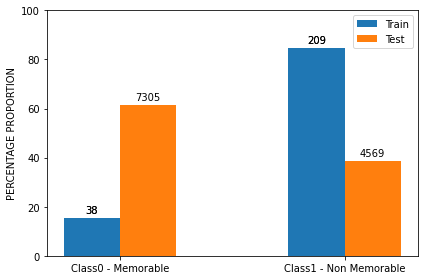

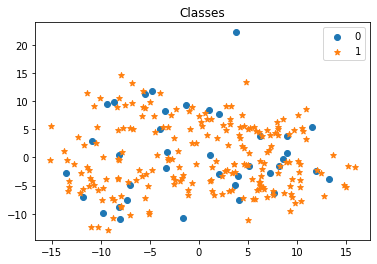

247

In [103]:
#@title PLOT ORIGINAL DISTRIBUTION
# BAR
plotbargraph(train)

# PCA -----
pca = PCA(n_components=2)

hold = train.iloc[:,1:-1]

X_pca = pca.fit_transform(hold)

plot_2d_space(X_pca, y)

len(X_pca)

Proportions
Training data:  Class0: 12.98%   Class1: 87.02%   Proportion: 0.1492 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


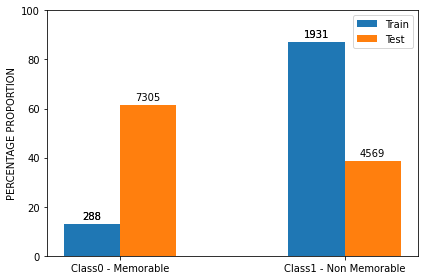

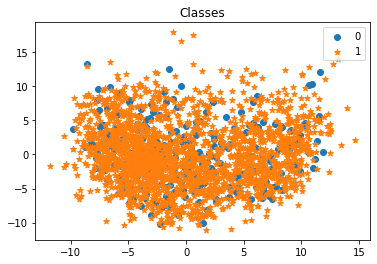

2219

In [104]:
#@title PLOT ADDITIONAL DATA DISTRIBUTION

# BAR
plotbargraph(additional_train)

# PCA -----
pca = PCA(n_components=2)

hold = additional_train.iloc[:,1:-1]

X_pca = pca.fit_transform(hold)

plot_2d_space(X_pca, additional_obsv)

len(X_pca)

Proportions
Training data:  Class0: 13.22%   Class1: 86.78%   Proportion: 0.1523 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


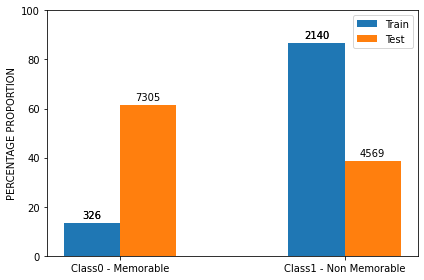

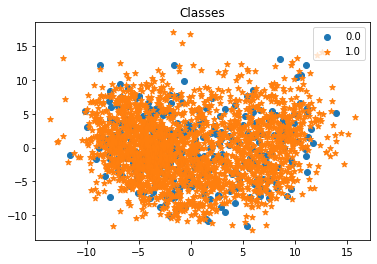

2466

In [105]:
#@title PLOT TOTAL DATA DISTRIBUTION

# BAR
plotbargraph(train_total)

# PCA -----
pca = PCA(n_components=2)

hold = train_total.iloc[:,1:-1]

X_pca = pca.fit_transform(hold)

plot_2d_space(X_pca, train_total_y)

len(X_pca)

In [0]:
#@title SAVE OVER TRAIN WITH TRAIN TOTAL FOR EASE ONWARDS

train = train_total

train_observed = train.iloc[:,-1] 

y = train_total_observed.to_numpy()

<br>

In [0]:
#@title FUNCTION - SKLEARN RESAMPLE (OVER-SAMPLE)
def resample_up(trn_total):
  # RESAMPLING.                             
  # ----------- Up sampling minority class.

  #train = pd.read_csv("/content/training.csv")

  # Minority class.
  c = 0 
  minority = trn_total.loc[trn_total["prediction"] == c]

  # Num. of samples equal across classes.
  num = len(trn_total) - 2 * len(minority)
  # Increase to match test data ratio if wanted.
  num = round(num * 1.7)

  print("{} rows added to trning data with class{} scores.".format(num, c))

  class0_upsampled = resample(minority,
                            replace=True,
                            n_samples=num,
                            random_state=seed
                            )

  # Concat new class0 sample and original trn.
  trn_total = pd.concat([trn_total, class0_upsampled])

  # Shuffle. 
  trn_total = shuffle(trn_total, random_state=seed)


  # Fix INDEX OF trn_total DATA.
  trn_total = trn_total.reset_index(drop=True).reset_index().drop(columns=["ID"])
  trn_total.columns.values[0] = "ID"
  trn_total["ID"] += 1


  # Update target array.
  # Get all observed predictions 0 / 1.
  trn_total_observed = trn_total.iloc[:, -1]
  # .values()
  trn_total_y = trn_total_observed.to_numpy(copy=True)

  return trn_total, trn_total_observed, trn_total_y

<br>

In [109]:
#@title USING FEATURE SELECTION

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X = train.iloc[:,1:-1]

# Chi^2, k=default=10.
selector = SelectKBest(chi2,k=1500)

# Variance Threshold
# selector = VarianceThreshold(threshold=(.8 * (1 - .8)))

# Fit transform training data.
X_selected = selector.fit_transform(X, y)
X_sel_df = pd.DataFrame(X_selected).reset_index()

# Transform test data.
test_sel = selector.transform(test.iloc[:,1:])
test_sel = pd.DataFrame(test_sel).reset_index()

# Reform pd.DF.
X_sel_df = pd.concat([X_sel_df,pd.DataFrame(y)],axis=1)

# Rename for over-sampling.
X_sel_df.columns = [*X_sel_df.columns[:-1], 'prediction']
X_sel_df.columns.values[0] = "ID"

# Check for GIST features.
X.iloc[:, selector.get_support()]

,CNNs.2,CNNs.7,CNNs.8,CNNs.10,CNNs.11,CNNs.14,CNNs.16,CNNs.18,CNNs.19,CNNs.23,CNNs.26,CNNs.30,CNNs.31,CNNs.35,CNNs.36,CNNs.38,CNNs.40,CNNs.41,CNNs.46,CNNs.51,CNNs.55,CNNs.56,CNNs.57,CNNs.59,CNNs.60,CNNs.61,CNNs.65,CNNs.67,CNNs.71,CNNs.81,CNNs.83,CNNs.85,CNNs.89,CNNs.93,CNNs.94,CNNs.95,CNNs.97,CNNs.98,CNNs.100,CNNs.103,...,CNNs.3999,CNNs.4000,CNNs.4001,CNNs.4005,CNNs.4007,CNNs.4008,CNNs.4009,CNNs.4018,CNNs.4020,CNNs.4021,CNNs.4023,CNNs.4028,CNNs.4030,CNNs.4031,CNNs.4037,CNNs.4038,CNNs.4043,CNNs.4047,CNNs.4048,CNNs.4051,CNNs.4052,CNNs.4061,CNNs.4062,CNNs.4063,CNNs.4064,CNNs.4065,CNNs.4066,CNNs.4067,CNNs.4070,CNNs.4072,CNNs.4074,CNNs.4077,CNNs.4078,CNNs.4080,CNNs.4081,CNNs.4083,CNNs.4088,CNNs.4090,CNNs.4091,CNNs.4095
0,0.0,0.84990,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.034718,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.389150,0.000000,0.25840,0.00000,0.000000,1.022400,0.00000,0.000000,0.734550,0.08112,0.000000,0.000000,1.507200,1.745600,0.000000,0.00000,0.000000,2.186500,0.551060,0.172240,0.000000,0.000000,1.479500,0.000000,...,0.00000,0.00000,0.000000,0.51262,0.00000,0.00000,0.000000,0.293130,0.000000,0.000000,0.000000,1.934300,0.046235,0.000000,0.47236,0.000000,0.048572,0.135560,0.00000,0.000000,3.011300,0.158610,0.000000,0.000000,0.542780,0.098366,0.000000,0.000000,0.220960,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.46046,0.0
1,0.0,0.00000,0.00000,0.000000,0.00000,0.000000,1.100400,0.000000,0.000000,1.062600,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,3.713700,1.728800,0.12591,0.00000,0.000000,0.000000,0.00000,0.871550,2.280100,1.20920,0.000000,0.000000,1.937300,0.000000,0.000000,0.00000,0.000000,2.136200,0.000000,0.055233,0.000000,0.000000,1.261300,0.000000,...,0.00000,1.19240,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.579070,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.218900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,2.73490,0.0
2,0.0,1.05840,0.51748,0.062792,0.00000,0.000000,0.000000,0.064824,0.000000,0.703270,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.278720,0.00000,0.000000,0.000000,0.24240,0.000000,0.000000,0.023387,0.634100,0.000000,0.00000,0.000000,1.218800,0.000000,0.638930,0.000000,0.000000,0.000000,0.206760,...,0.00000,0.00000,0.000000,0.00000,0.36052,0.00000,0.000000,0.420270,0.075211,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.160330,0.268260,0.00000,0.000000,0.145800,0.000000,0.000000,0.089618,0.000000,0.000000,0.082653,0.000000,1.545100,0.00000,0.000000,0.111720,0.000000,0.000000,0.000000,0.0,0.184430,0.0000,0.34659,0.0
3,0.0,0.35810,0.86264,0.000000,0.00000,0.000000,0.000000,0.000000,0.131750,0.000000,0.000000,0.00000,0.00000,1.92750,0.000000,0.000000,1.427300,0.271040,0.10315,0.66091,0.000000,0.000000,0.00000,0.000000,0.000000,0.25448,0.506120,0.000000,0.000000,0.694620,0.000000,0.00000,0.000000,0.000000,0.000000,0.026381,0.000000,0.245330,0.836250,0.000000,...,0.74503,0.00000,0.000000,0.00000,0.00000,0.41212,0.000000,0.000000,0.546300,0.620090,1.509000,0.000000,0.000000,0.161660,0.00000,0.735060,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005592,0.100540,0.000000,0.145580,0.000000,0.00000,0.000000,0.529040,0.000000,0.053934,0.000000,0.0,0.000000,0.0000,0.00000,0.0
4,0.0,0.51557,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.059300,0.000000,0.00000,0.00000,0.77977,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.365760,0.00000,0.000000,0.000000,0.00000,0.000000,0.648880,0.498030,0.000000,0.000000,0.00000,0.000000,1.299300,0.000000,1.654800,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,1.13130,0.00000,0.00000,0.000000,0.000000,0.519360,0.000000,0.041767,0.129790,0.000000,0.000000,0.00000,0.000000,0.200140,1.889400,0.00000,0.0000

In [110]:
#@title SKLEARN RESAMPLE(OVERSAMPLE) ONLY FEATURE SELECTED DATA

train_sel, train_obs_sel, train_y_sel = resample_up(X_sel_df)

3084 rows added to trning data with class0 scores.


Proportions
Training data:  Class0: 61.44%   Class1: 38.56%   Proportion: 1.5934 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


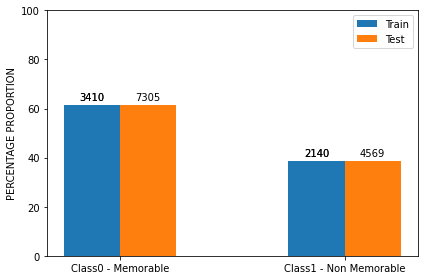

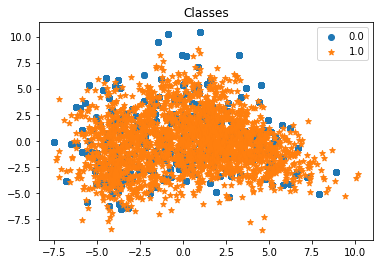

5550

In [111]:
#@title PLOT FEATURE SELECTED DISTIBUTION

plotbargraph(train_sel)
# PCA
pca = PCA(n_components=2)

hold = train_sel.iloc[:,1:-1]

X_pca = pca.fit_transform(hold)

plot_2d_space(X_pca, train_y_sel)

len(X_pca)

In [0]:
#@title FEATURE SCALING FOR SELECT DATA

df_train = train_sel.iloc[:,1:-1]
vals_train = df_train.to_numpy(copy=True)

df_test = test_sel.iloc[:,1:]
vals_test = df_test.to_numpy(copy=True)

# Get mean and std. from training data.
mean = vals_train.mean()
std = vals_train.std()

# Transform training then testing data.
vals_train = (vals_train - mean) / std
vals_test = (vals_test - mean) / std

In [0]:
#@title SETUP PARAMETERS FOR CLASSIFIER(S) USING SELECT DATA

# Params:
# Feature data.
X = vals_train
# Feature test data.
test_data = vals_test
# Predictions
y = train_sel.iloc[:,-1]


hddn_lyrs = (100,100,100,100)
mx_itr = 100

# No diff so far.
lr = { "c" : 'constant', "i": 'invscaling', "a":'adaptive'}

<br>

In [15]:
#@title SKLEARN RESAMPLE(OVERSAMPLE) - TOTAL DATA

train, train_observed, train_y = resample_up(train)

3084 rows added to trning data with class0 scores.


Proportions
Training data:  Class0: 61.44%   Class1: 38.56%   Proportion: 1.5934 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


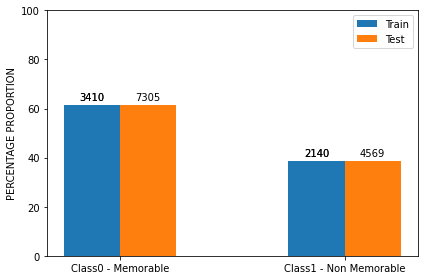

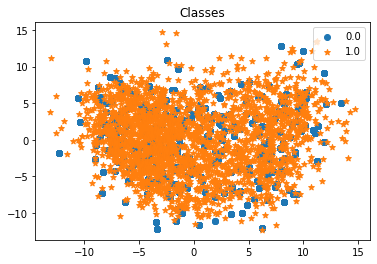

5550

In [16]:
#@title PLOT RESAMPLED DISTRIBUTION
# BAR
plotbargraph(train)

# PCA
pca = PCA(n_components=2)

hold = train.iloc[:,1:-1]

X_pca = pca.fit_transform(hold)

plot_2d_space(X_pca, train_y)

len(X_pca)

<br>

In [0]:
#@title FEATURE SCALING - MANUAL STANDARDIZATION - FUNCTION

def manual_standardization(trn, tst, rtn_DF=False):
  # ------ Set up training and testing data.

  # Split standardizer by hand.
  # Training data.
  df_cnn = trn.iloc[:, 1:-513]
  df_gist = trn.iloc[:, -513:-1]

  X_cnn = df_cnn.to_numpy(copy=True)
  X_gist = df_gist.to_numpy(copy=True)

  # Testing data.
  df_test_cnn = tst.iloc[:,1:-512]
  df_test_gist = tst.iloc[:,-512:]

  test_values_cnn = df_test_cnn.to_numpy(copy=True)
  test_values_gist = df_test_gist.to_numpy(copy=True)


  # Set scale method.
  scale_setting = 1

  if scale_setting == 0:
    # Standardize training data.
    scaler = MinMaxScaler()
    X_cnn = scaler.fit_transform(X_cnn)
    test_values_cnn = scaler.transform(test_values_cnn)

    # Standardize training data.
    scaler = MinMaxScaler()
    X_gist = scaler.fit_transform(X_gist)
    test_values_gist = scaler.transform(test_values_gist)

  elif scale_setting == 1:
    # CNN scaling.
    mean = X_cnn.mean()
    std = X_cnn.std()

    X_cnn = (X_cnn - mean) / std
    test_values_cnn = (test_values_cnn - mean) / std

    # GIST scaling.
    mean = X_gist.mean()
    std = X_gist.std()

    X_gist = (X_gist - mean) / std
    test_values_gist = (test_values_gist - mean) / std


  #Create final np arrays for training/test.
  X_standardized = np.concatenate((X_cnn,X_gist),axis=1)
  test_data_standardized = np.concatenate((test_values_cnn,test_values_gist),axis=1)

  if rtn_DF:
    # Create new dataframe holding standardized data.
    reshaped_0 = pd.DataFrame(X_standardized).reset_index()
    trn_observed = trn.iloc[:, -1]
    df = pd.concat([reshaped_0,trn_observed], axis=1)
    # Rename columns for consistency. 
    df = pd.DataFrame(data=df.values, columns=trn.columns)
    return X_standardized, test_data_standardized, df

  return X_standardized, test_data_standardized

In [0]:
#@title SETUP PARAMETERS FOR CLASSIFIER(S)

# Training dataframe here (ensures predictions columns consistent)
trn_df = train

# Create scaled data.
X_standardized, test_data_standardized = manual_standardization(trn_df, test)

# Params:
# Feature data.
X = X_standardized
# Feature test data.
test_data = test_data_standardized
# Predictions
y = trn_df.iloc[:,-1]


hddn_lyrs = (100,100,100,100)
mx_itr = 100

# No diff so far.
lr = { "c" : 'constant', "i": 'invscaling', "a":'adaptive'}

<br>

In [0]:
#@title ROUGH ESTIMATOR FUNCTION
# Calculate extremely rough "accuracy" from proportion of data correct.
def estimate(preds_final):
  class_0 = 0
  class_1 = 0

  for val in preds_final:
    if val == 0:
      class_0 += 1
    elif val == 1:
      class_1 += 1

  total = len(preds_final)

  pred_0 = round((class_0 / total), 4)
  pred_1 = round((class_1 / total), 4) 

  actual_0 = float(test_proportions.iloc[0,0][:6])
  actual_1 = round((1 - actual_0),4)

  dif = abs(pred_0 - actual_0)
  percent_dif = dif / np.mean([pred_0,actual_0]) * 100

  print("Class 0 Non memorable: \nPredicted proportion: {} \nActual proportion:    {}\n".format(pred_0,actual_0))
  print("Class 1 Memorable: \nPredicted proportion: {} \nActual proportion:    {}\n".format(pred_1,actual_1))
  print("Percentage difference pred_0 and actual_0 is:\n{}%\nDifference of:\n{}".format(round(percent_dif,2), round(dif,4)))

In [94]:
# MLP Classifier.
clf = MLPClassifier(solver="adam",
                        activation="logistic",
                        hidden_layer_sizes=hddn_lyrs,
                        max_iter=mx_itr,
                        alpha=1e-5,
                        random_state=1,
                        learning_rate=lr["c"]
                        )

clf.fit(X,y)

# Predictions.
predictions_final = clf.predict(test_data)

estimate(predictions_final)

# 0.624 best ----> 0.76684% Using "adam" / "logistic" and using total data with chi^2 k=1500 feature selection.

Class 0 Non memorable: 
Predicted proportion: 0.6206 
Actual proportion:    0.6152

Class 1 Memorable: 
Predicted proportion: 0.3794 
Actual proportion:    0.3848

Percentage difference pred_0 and actual_0 is:
0.87%
Difference of:
0.0054


In [125]:
#@title KERAS MLP APPROX SCORE 0.76 (MAYBE)

# Yields a decent score however an incredibily large number of hidden layers/ neurons - probably not justifiable.

from keras.models import Sequential
from keras.layers import Dense, Dropout


model = Sequential()
model.add(Dense(1500, input_dim=1500, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dense(750, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y,
          epochs=5)
        # , batch_size=4608)
# score = model.evaluate(x_test, y_test, batch_size=4608)



predictions_final = model.predict(test_data)

predictions_final = np.around(predictions_final).flatten().astype("int")

estimate(predictions_final)

# #https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

Epoch 1/5
5550/5550 [==============================] - 9s 2ms/step - loss: 0.4402 - accuracy: 0.7919
Epoch 2/5
5550/5550 [==============================] - 9s 2ms/step - loss: 0.1047 - accuracy: 0.9638
Epoch 3/5
5550/5550 [==============================] - 9s 2ms/step - loss: 0.0527 - accuracy: 0.9847
Epoch 4/5
5550/5550 [==============================] - 9s 2ms/step - loss: 0.0583 - accuracy: 0.9852
Epoch 5/5
5550/5550 [==============================] - 9s 2ms/step - loss: 0.0442 - accuracy: 0.9868
Class 0 Non memorable: 
Predicted proportion: 0.6143 
Actual proportion:    0.6152

Class 1 Memorable: 
Predicted proportion: 0.3857 
Actual proportion:    0.3848

Percentage difference pred_0 and actual_0 is:
0.15%
Difference of:
0.0009


In [0]:
slvr = ["adam","lbfgs","sgd"]
activations = ['identity', 'logistic', 'tanh', 'relu']

for solve in slvr:
  for act in activations:
    print("'{}' solver".format(solve))
    print("'{}' activation function".format(act))
    # MLP Classifier.
    clf = MLPClassifier(solver=solve,
                        activation=act,
                        hidden_layer_sizes=hddn_lyrs,
                        max_iter=mx_itr,
                        alpha=1e-5,
                        random_state=1,
                        learning_rate=lr["c"]
                        )

    clf.fit(X,y)

    # Predictions.
    predictions_final = clf.predict(test_data)

    estimate(predictions_final)
    print("\n\n")

# Curr score - 0.68092 - "adam"

In [0]:
catch this cell

In [0]:
# Convert to INT:
predictions_final = predictions_final.astype("int")

# Create and download .csv file.
rnge = np.arange(1,len(predictions_final)+1)
df = pd.DataFrame({"ID": rnge, "prediction": predictions_final})
df.to_csv("submission1.csv", index=False)

In [0]:
#!ls

In [149]:
# Run to submit to Kaggle competition.
!kaggle competitions submit brighton-a-memorable-city -f submission1.csv -m "woo"

100% 81.9k/81.9k [00:08<00:00, 9.54kB/s]
Successfully submitted to Brighton, a memorable city!

In [0]:
files.download("submission1.csv")

In [0]:
sub1 = pd.read_csv("/content/submission1.csv")

In [0]:
# 0.6152 class 0      non memorable.
# 0.3848 class 1      memorable.

### Scores:

**Sklearn MLP - Estimate: 0.5873, Kaggle: 0.76583**
* additional data 
* sklearn oversampler 
* custom standardizer

**Current Best Sklearn MLP - Estimate: 0.624, Kaggle: 0.76684**
* additional data 
* sklearn feature selection - SelectKBest(chi2,k=1500)
* sklearn oversampler 
* custom standardizer



<br>

In [0]:
#@title CLASSIFIER LIST HOLDER
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

clfs = [RandomForestClassifier(max_features="sqrt",
                             max_depth=None,
                             min_samples_split=2
                             ),
        svm.SVC(kernel="rbf"),
        DecisionTreeClassifier(random_state=seed)
        ]

for clf in clfs:
  print(type(clf))
  clf.fit(X,y)
  predictions_final = clf.predict(test_data)
  estimate(predictions_fina l)
  print("\n\n")


<br>

In [0]:
#@title USING FEATURE SELECTION

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import VarianceThreshold


# X = train.iloc[:,1:-1]

# # Chi^2, k=default=10.
# selector = SelectKBest(chi2,k=6)
# selector = VarianceThreshold(threshold=(.8 * (1 - .8)))

# # Fit transform training data.
# X_selected = selector.fit_transform(X, y)
# X_sel_df = pd.DataFrame(X_selected).reset_index()

# # Transform test data.
# test_sel = selector.transform(test.iloc[:,1:])
# test_sel = pd.DataFrame(test_sel).reset_index()

# # Reform pd.DF.
# X_sel_df = pd.concat([X_sel_df,pd.DataFrame(y)],axis=1)

# # Rename for over-sampling.
# X_sel_df.columns = [*X_sel_df.columns[:-1], 'prediction']
# X_sel_df.columns.values[0] = "ID"

# # Check for GIST features.
# X.iloc[:, selector.get_support()]

In [0]:
#@title CHI^2 FEATURE SELECTION TOP FEATURES

# X = train.iloc[:,1:-1]
# # Chi^2, k=default=10.
# selector = SelectKBest(chi2,k=6)
# fit = selector.fit(X,y)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# #concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Features:','Score']  #naming the dataframe columns
# pd.DataFrame(featureScores.nlargest(6,'Score'))

# # https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [0]:
#@title SKLEARN RESAMPLE(OVERSAMPLE) ONLY FEATURE SELECTED DATA

train_sel, train_obs_sel, train_y_sel = resample_up(X_sel_df)

3084 rows added to trning data with class0 scores.


In [0]:
#@title PLOT FEATURE SELECTED DISTIBUTION

plotbargraph(train_sel)
# PCA
pca = PCA(n_components=2)

hold = train_sel.iloc[:,1:-1]

X_pca = pca.fit_transform(hold)

plot_2d_space(X_pca, train_y_sel)

len(X_pca)

In [0]:
#@title FEATURE SCALING FOR SELECT DATA

df_train = train_sel.iloc[:,1:-1]
vals_train = df_train.to_numpy(copy=True)

df_test = test_sel.iloc[:,1:]
vals_test = df_test.to_numpy(copy=True)

# Get mean and std. from training data.
mean = vals_train.mean()
std = vals_train.std()

# Transform training then testing data.
vals_train = (vals_train - mean) / std
vals_test = (vals_test - mean) / std

In [0]:
#@title SETUP PARAMETERS FOR CLASSIFIER(S) USING SELECT DATA

# Params:
# Feature data.
X = vals_train
# Feature test data.
test_data = vals_test
# Predictions
y = train_sel.iloc[:,-1]


hddn_lyrs = (100,100,100,100)
mx_itr = 100

# No diff so far.
lr = { "c" : 'constant', "i": 'invscaling', "a":'adaptive'}

<br>

In [0]:
#@title SKLEARN RESAMPLE (OVER-SAMPLE)
# # RESAMPLING.                             # Curr score - 0.68092
# # ----------- Up sampling minority class.

# #train = pd.read_csv("/content/training.csv")

# # Minority class.
# c = 0 
# minority = train.loc[train["prediction"] == c]

# # Num. of samples equal across classes.
# num = len(train) - 2 * len(minority)
# # Increase to match test data ratio if wanted.
# num = round(num * 1.7)

# print("{} rows added to training data with class{} scores.".format(num, c))

# class0_upsampled = resample(minority,
#                            replace=True,
#                            n_samples=num,
#                            random_state=seed
#                            )

# # Concat new class0 sample and original train.
# train = pd.concat([train, class0_upsampled])

# # Shuffle. 
# train = shuffle(train, random_state=seed)


# # Fix INDEX OF TRAIN DATA.
# train = train.reset_index(drop=True).reset_index().drop(columns=["ID"])
# train.columns.values[0] = "ID"
# train["ID"] += 1


# # Update target array.
# # Get all observed predictions 0 / 1.
# train_observed = train.iloc[:, -1]
# # .values()
# y = train_observed.to_numpy(copy=True)

In [0]:
#@title SKLEARN RESAMPLE (OVER-SAMPLE) USING TOTAL DATA
# # RESAMPLING.                             
# # ----------- Up sampling minority class.

# #train = pd.read_csv("/content/training.csv")

# # Minority class.
# c = 0 
# minority = train_total.loc[train_total["prediction"] == c]

# # Num. of samples equal across classes.
# num = len(train_total) - 2 * len(minority)
# # Increase to match test data ratio if wanted.
# num = round(num * 1.7)

# print("{} rows added to training data with class{} scores.".format(num, c))

# class0_upsampled = resample(minority,
#                            replace=True,
#                            n_samples=num,
#                            random_state=seed
#                            )

# # Concat new class0 sample and original train.
# train_total = pd.concat([train_total, class0_upsampled])

# # Shuffle. 
# train_total = shuffle(train_total, random_state=seed)


# # Fix INDEX OF TRAIN_total DATA.
# train_total = train_total.reset_index(drop=True).reset_index().drop(columns=["ID"])
# train_total.columns.values[0] = "ID"
# train_total["ID"] += 1


# # Update target array.
# # Get all observed predictions 0 / 1.
# train_total_observed = train_total.iloc[:, -1]
# # .values()
# train_total_y = train_total_observed.to_numpy(copy=True)

In [0]:
#@title IMBLEARN ASSORTED RESAMPLERS (OVERSAMPLING) -- SMOTE ETC.

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC
#from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import RandomOverSampler

# Reset if needed.
train = pd.read_csv("/content/training.csv")
train_observed = train.iloc[:, -1]

# vvvvvvv RUN AND SUBMIT THIS LAST ONE vvvvvvv
ovrsmplr = RandomOverSampler(random_state=seed)

X_res, _ = ovrsmplr.fit_resample(train, train_observed)
print("{} rows added to training data with class0 scores.\n".format(len(X_res)-len(train)))
train = pd.DataFrame(X_res)

train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True) 

In [0]:
#@title IMBLEARN SMOTE (OVER-SAMPLE)

from imblearn.over_sampling import SMOTE

# Train Data here.
trn = train

# Create SMOTE resampler.
sm = SMOTE(random_state=seed)

# resample(TrainDataOnly, PredictionsOnly)
X_res, y_res = sm.fit_resample(trn.iloc[:,:-1], trn.iloc[:,-1])
# X_res holds data without predictions, y_res is predictions.

X_df = pd.DataFrame(X_res)
y_df = pd.DataFrame(y_res)

# USE TRAIN ONWARDS.
# Concat to mimic og. train.
holder = pd.concat([X_df,y_df], axis=1)
train = pd.DataFrame(data=holder.values, columns=trn.columns)
# Predictions.
train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True) 

In [0]:
#@title SMOTETOMEK COMBINE RESAMPLER
# from imblearn.combine import SMOTETomek

# v_curr = len(train)

# gg = train.iloc[:,1:-1]

# smt = SMOTETomek(ratio='auto', random_state=seed)
# X_smt, y_smt = smt.fit_resample(gg, train_observed)

# df_X_smt = pd.DataFrame(X_smt)
# df_y_smt = pd.DataFrame(y_smt)

# df_total = pd.concat([df_X_smt,df_y_smt], axis=1)


# train = df_total.reset_index()

# v_curr = len(train) - v_curr
# print("{} rows added to training data".format(v_curr))

# # Shuffle. 
# train = shuffle(train, random_state=seed)

# # Update target array.
# # Get all observed predictions 0 / 1.
# train_observed = train.iloc[:, -1]
# # .values()
# y = train_observed.to_numpy(copy=True)

In [0]:
#@title SMOTEEEN COMBINE RESAMPLER
# from imblearn.combine import SMOTEENN

# v_curr = len(train)

# gg = train.iloc[:,1:-1]

# smt = SMOTEENN(ratio='auto', random_state=seed)
# X_smt, y_smt = smt.fit_resample(gg, train_observed)

# df_X_smt = pd.DataFrame(X_smt)
# df_y_smt = pd.DataFrame(y_smt)

# df_total = pd.concat([df_X_smt,df_y_smt], axis=1)


# train = df_total.reset_index()

# v_curr = len(train) - v_curr
# print("{} rows added to training data".format(v_curr))

# # Shuffle. 
# train = shuffle(train, random_state=seed)

# # Update target array.
# # Get all observed predictions 0 / 1.
# train_observed = train.iloc[:, -1]
# # .values()
# y = train_observed.to_numpy(copy=True)

In [0]:
#@title TOMEKS LINKS UNDERSAMPLING METHODS.
# Tomeks links --------------------

# # RESAMPLING.
# # ---------- Remove from majority class.

# # Removing TomekLinks.
# df_cnn = train.iloc[:, 1:-513]
# df_gist = train.iloc[:, -513:-1]

# # CNN features.
# t1 = TomekLinks(return_indices=True, ratio="majority")
# X_t1, y_t1, id_t1 = t1.fit_resample(df_cnn, train_observed)

# # GIST features.
# t2 = TomekLinks(return_indices=True, ratio="majority")
# X_t2, y_t2, id_t2 = t2.fit_resample(df_gist, train_observed)

# # List to hold Tomek's links indicies.
# index_removal = list()
# for index in np.arange(len(train)):
#   if index in id_t1:
#     pass
#   else:
#     index_removal.append(index)
#   if index in id_t2:
#     pass
#   else:
#     index_removal.append(index)


# # Remove specified indicies from train.
# train = train.drop(index_removal)

# # Get all observed predictions 0 / 1.
# train_observed = train.iloc[:, -1]
# # .values()
# y = train_observed.to_numpy(copy=True)


# print("{} rows removed from train.target['class1'] majority class.".format(len(index_removal)))

<br>

In [0]:
#@title GROUPED TWIN AXIS BAR PLOT


# # Data representation:

# # Training ---
# trn_c0 = np.count_nonzero(y == 0)
# trn_c1 = np.count_nonzero(y == 1)

# plsdeleteAFTER = [trn_c0,trn_c1] #########
# autolabel_vals = [trn_c0,trn_c1] # Hold vals for rect labels.

# trn_c0 = round((trn_c0/len(y)*100),2)
# trn_c1 = round((trn_c1/len(y)*100),2)
# trn_bar = [trn_c0,trn_c1] # Hold vals for bar plot.


# # Testing ---
# tst_c0 = float(test_proportions.iloc[0,0][:6])

# # Hold vals for rect labels.
# autolabel_vals.append(tst_c0*len(test))
# autolabel_vals.append((1-tst_c0)*len(test))
# plsdeleteAFTER = [tst_c0*len(test),(1-tst_c0)*len(test)] #####

# tst_c0 = round((tst_c0*100),2)
# tst_c1 = 100 - tst_c0
# tst_bar = [tst_c0,tst_c1] # Hold vals for bar plot.


# print("Proportions")
# print("Training data:  Class0: {}%   Class1: {}%".format(trn_c0,trn_c1) +
#       "   Proportion: {} : 1".format(round((trn_c0/trn_c1),4)))
# print("Testing data:   Class0: {}%   Class1: {}%".format(tst_c0,tst_c1) + 
#       "   Proportion: {} : 1".format(round((tst_c0/tst_c1),4)))


# # Bar Plot.
# labels = ["Class0 - Memorable", "Class1 - Non Memorable"]
# x = np.arange(len(labels))
# width = 0.25

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, trn_bar, width, label='Train')
# rects2 = ax.bar(x + width/2, tst_bar, width, label='Test')

# colour = "tab:blue"
# ax.set_ylabel("TRAINING DATA", color=colour)
# ax.set_ylim([0,100])
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# ax2 = ax.twinx()
# colour = "tab:orange"
# ax2.set_ylabel("TESTING DATA", color=colour)
# ax2.tick_params(axis="y", color=colour)

# ############
# # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
# def autolabel(rects):
#   for i, rect in enumerate(rects):
#     height = rect.get_height()
#     ax.annotate('{}%'.format(height),
#                 xy=(rect.get_x() + rect.get_width() / 2, height),
#                 xytext=(0, 3),  # 3 points vertical offset
#                 textcoords="offset points",
#                 ha='center', va='bottom')
# ############


# autolabel(rects1)
# autolabel(rects2)

# fig.tight_layout()

# plt.show()

<BR>

In [0]:
#@title PIPELINE SET UP & RUN

# # PIPELINE
# clf = make_pipeline(MLPClassifier(solver="lbfgs",
#                                                                             hidden_layer_sizes=hddn_lyrs,
#                                                                             max_iter=mx_itr,
#                                                                             alpha=1e-5,
#                                                                             random_state=1,
#                                                                             learning_rate=lr["c"]))
# clf.fit(X, y)

# predictions_final = clf.predict(test_data)

# estimate(predictions_final)

# clf.steps

In [0]:
#@title CUSTOM FUNCTION TRANSFORMERS FOR PIPELINE

# from sklearn.preprocessing import FunctionTransformer

# def plus(X):
#   X + 1
#   return X

# transformer = FunctionTransformer(plus)
# X = np.array([[0, 1], [2, 3]])
# transformer.transform(X)

<BR>

In [0]:
# @title MAXABS - SCALER

# from sklearn.preprocessing import MaxAbsScaler

# scaler = MaxAbsScaler()
# X = scaler.fit_transform(X)
# test_data = scaler.transform(test_data)

<BR>

In [0]:
#@title SKLEARN RANDOM FOREST CLF

from sklearn.ensemble import RandomForestClassifier

# RANDOMFOREST Classifier.
clf = RandomForestClassifier(max_features="sqrt",
                             max_depth=None,
                             min_samples_split=2
                             )

clf.fit(X,y)

predictions_final = clf.predict(test_data)

estimate(predictions_final)

In [0]:
#@title SKLEARN SVM CLF
from sklearn import svm

# SVM Classifier.

clf = svm.SVC(kernel="sigmoid")

clf.fit(X,y)

predictions_final = clf.predict(test_data)

estimate(predictions_final)

# https://scikit-learn.org/stable/modules/svm.html

In [0]:
#@title SKLEARN DECISION TREE CLF

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=seed)

clf.fit(X,y)

# Predictions.
predictions_final = clf.predict(test_data)

estimate(predictions_final)

In [0]:
#@title SKLEARN DECISION TREE CLF - GRAPHICAL TREE REP
# from sklearn import tree

# clf = tree.DecisionTreeClassifier(random_state=seed)

# clf = clf.fit(X,y)

# tree.plot_tree(clf.fit(X,y))

In [0]:
#@title KERAS MLP APPROX SCORE 0.76 (MAYBE)

# Yields a decent score however an incredibily large number of hidden layers/ neurons - probably not justifiable.

from keras.models import Sequential
from keras.layers import Dense, Dropout


model = Sequential()
model.add(Dense(1536, input_dim=4608, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1536, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1536, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y,
          epochs=30)
        # , batch_size=4608)
# score = model.evaluate(x_test, y_test, batch_size=4608)



predictions_final = model.predict(test_data)
print(predictions_final)

predictions_final = np.around(predictions_final).flatten().astype("int")

estimate(predictions_final)